# **IT응용시스템공학과**
## **1594016 박관익** 

### **Find Waldo (월리를 찾아라)** : Finding Waldo with CNN

**GitHub : https://github.com/kairess/find_waldo**

**Dataset : https://www.kaggle.com/kairess/find-waldo**

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**패키지 설치**

In [2]:
# numpy, matplotlib, keras, seaborn, PIL, skimage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize

import threading, random, os

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


**Load Dataset**

In [ ]:
imgs = np.load('dataset/imgs_uint8.npy').astype(np.float32) / 255.                            # 전체 원본 이미지
labels = np.load('dataset/labels_uint8.npy').astype(np.float32) / 255.                        # 전체 원본 이미지 마스크
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy', allow_pickle=True) / 255.        # 월리 이미지
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy', allow_pickle=True) / 255.    # 월리 이미지 마스크

print(imgs.shape, labels.shape)                                                               # 2800x1760x3 18개 이미지 
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)                                           # 18개의 월리 이미지

(18, 1760, 2800, 3) (18, 1760, 2800)
(18,) (18,)


**Data Generator**

랜덤으로 자르고, 랜덤으로 좌우변환 

In [ ]:
PANNEL_SIZE = 224                                                # 기본 PANNEL 사이즈를 224로 고정                          

# 뒤섞인 인덱스를 생성하는 BatchIndices() 클래스
class BatchIndices(object):
    """
        n: 인덱스 갯수
        bs: 배치 사이즈
        shuffle: 인덱스의 셔플 여부, 기본값은 False 
    """
    # 기본 생성자
    def __init__(self, n, bs, shuffle=False):
        self.n, self.bs, self.shuffle = n, bs, shuffle
        self.lock = threading.Lock()                              # lock을 acuire하면, 해당 쓰레드만 공유 데이터에 접근
        self.reset()                               

    # idxs, curr 값 초기화 
    def reset(self):
        self.idxs = (np.random.permutation(self.n)                # 인덱스의 갯수만큼 array를 복사하여 무작위로 섞어서 반환
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    # 커스텀 이터레이터 생성
    def __next__(self):
        with self.lock:
            if self.curr >= self.n : self.reset()                  # curr가 인덱스 갯수보다 클 때 reset()
            ni = min(self.bs, self.n - self.curr)                  # bs와 n-curr 최솟값 ni 생성
            res = self.idxs[self.curr : self.curr + ni]            # ni만큼 idxs 슬라이싱하여 res 생성 
            self.curr += ni                                        
            return res                                    

In [ ]:
# 서브 이미지의 배치를 생성하는 segm_generator() 클래스
class segm_generator(object):
    """
        x: 입력한 배열
        y: 배열 타겟값 
        bs: 배치 사이즈
        out_sz: 서브이미지의 크기
        train: true이면, 서브 이미지를 셔플 / 랜덤 
        waldo: true이면, 서브 이미지에 타겟값을 포함
    """

    # 기본 생성자
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x, y, bs, train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape                                                
            self.ri.append(ri), self.ci.append(ci)                                # 입력 shape값  ri, ci 저장
        self.idx_gen = BatchIndices(self.n, bs, train)                            # 섞인 인덱스 idx_gen                     
        self.ro, self.co = out_sz                                                 # 결과 크기 ro, co
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1                     

    # 랜덤으로 이미지 자르기
    def get_slice(self, i, o):
        start = random.randint(0, i-o) if self.train else (i-o)                    
        return slice(start, start+o)                                              # (start ~ start+0)로 이미지 자르기

    # 확률적으로 좌우반전
    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)                           
        slice_c = self.get_slice(self.ci[idx], self.co) 
        x = self.x[idx][slice_r, slice_c]                                         # 가로길이 슬라이싱
        y = self.y[idx][slice_r, slice_c]                                         # 세로길이 슬라이싱
        if self.train and (random.random()>0.5):                                  # 0.5의 확률로 좌우반전 (거울반전)
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None

        # 라밸 원핫인코딩 변환 : 월리가 있는 곳은 1, 없는 곳은 0으로 표현
        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2)) 

    # 커스텀 이터레이터 생성
    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)

In [ ]:
# 월리가 포함된 이미지와 포함되지 않은 이미지 데이터 섞기
# 총 배치 사이즈에서 0.34의 비율로 224x224 결과 생성 
def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
    """
        x1, y1: 월리 서브이미지 입력/결과
        x2, y2: 전체 원본이지미 입력/결과
        tot_bs: 총 배치 사이즈
        prop: 첫 번째 데이터 생성으로 구성되는 총 배치 사이즈의 비율
    """
    n1 = int(tot_bs * prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)                    # 월리 서브이미지
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)       # 전체 원본이미지
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

**Preview Sample Pannel Images**

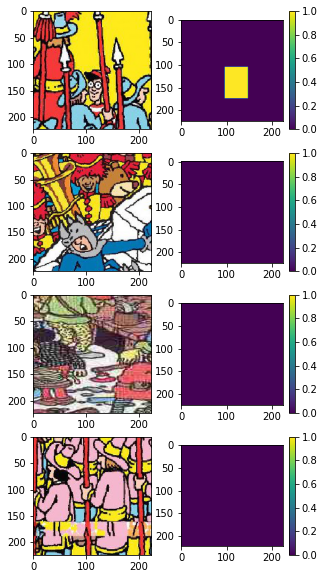

In [ ]:
# 월리o : 월리x = 1 : 2 (0.34) 
# 총 배치사이즈 4개, 월리의 비율은 1/3, 패널사이즈 224x224 이미지 gen_mix 생성
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

# 다음 배치의 데이터 가져오기
X, y = next(gen_mix)

# 시각화
# 월리가 포함된곳 : 1 (노란색), 나머지 : 0 (보라색)
plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

**Plot Y-Data Distribution**

biased(skewed) sample : y값들의 불균형적인 데이터셋 (극히 적은 월리가 있는 패널갯수)

88666846 37154


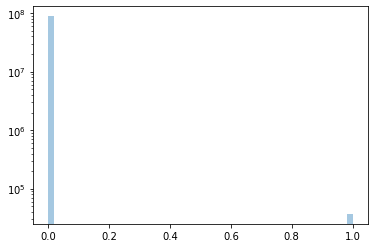

In [ ]:
freq0 = np.sum(labels==0) # 월리가 없는 데이터
freq1 = np.sum(labels==1) # 월리가 있는 데이터

# 갯수 출력
print(freq0, freq1)

# skewed sample 시각화
sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})

**Make Class Weights (0 and 1)**

모델에게 output을 미리 명시해주는 class weight : 모델이 비슷하게 출력하도록 유도

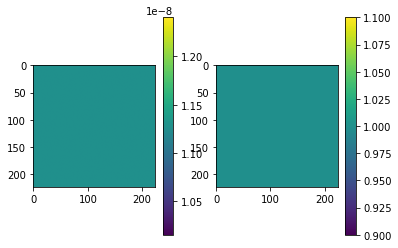

In [ ]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))    # output과 같은 224x224 크기의 sample weights 

sample_weights[:,:,0] = 1. / freq0
sample_weights[:,:,1] = 1.

# sample weights 시각화
plt.subplot(1,2,1)
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))           # 0으로 채워진 첫번째 패널
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))           # 1로 채워진 두번째 패널
plt.colorbar()

**Create Model**

In [ ]:
# CNN 모델 생성
inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))        # input shape 224x224x3

net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)                          # 첫번째 MaxPooling (차원 감소)

shortcut_1 = net                                                  # 첫번째 shortcut

net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)                          # 두번째 MaxPooling (차원 감소)

shortcut_2 = net                                                  # 두번째 shortcut

net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)                          # 세번째 MaxPooling (차원 감소)

shortcut_3 = net                                                  # 세번째 shortcut

net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)                          # 네번째 MaxPooling (차원 감소)

net = layers.UpSampling2D(size=2)(net)                            # 첫번째 UpSampling (차원 확대)
net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_3])                             # 세번째 shortcut

net = layers.UpSampling2D(size=2)(net)                            # 두번째 UpSampling (차원 확대)
net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_2])                             # 두번째 shortcut

net = layers.UpSampling2D(size=2)(net)                            # 세번째 UpSampling (차원 확대)
net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_1])                             # 첫번째 shortcut

net = layers.UpSampling2D(size=2)(net)                            # 네번째 UpSampling (차원 확대)
net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

net = layers.Reshape((-1, 2))(net)                                # 224x224 2개의 채널로 reshape
net = layers.Activation('softmax')(net)                           # 2개 채널간의 합이 1이 되도록 softmax 사용

model = Model(inputs=inputs, outputs=net)

# 모델 컴파일
model.compile(
    loss='categorical_crossentropy',                              # categorical_crossentropy
    optimizer=optimizers.Adam(),                                  # Adam optimizer
    metrics=['acc'],                                              # 모델 정확도
    sample_weight_mode='temporal'                                 # class weight를 사용하기 위해
)

# 모델 요약
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 224, 224, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 64) 0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

**Train**

 Epoch:  499 - loss: 0.0109 - acc: 0.9962

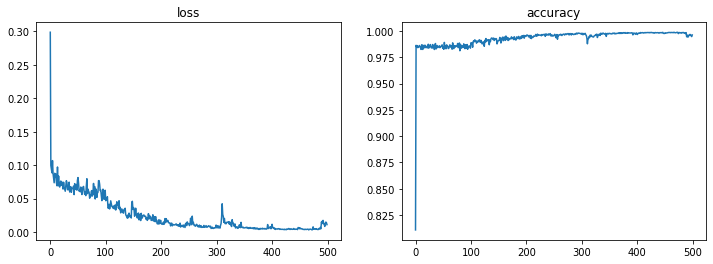

In [ ]:
# seg_ge_mix를 통한 gen_mix 저장 (월리의 이미지를 0.34만큼 포함하는 배치사이즈 6, 224x224 output 생성)
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

# Lambda 콜백을 사용하여 지워가면서 loss, acc 출력 (5줄 이내로)
def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'], logs['acc']), end='')

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# 생성된 gen_mix를 500번의 epoch, 한 epoch에 사용한 step은 6으로 모델 학습
# class weight를 만들어놓은 sample weight로 넣어주기
# Lambda 콜백 설정 (patience : 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인지, mode : auto)
history = model.fit_generator(
    gen_mix, steps_per_epoch=6, epochs=500, 
    class_weight=sample_weights,
    verbose=0,
    callbacks=[
        print_callback,
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

# 모델 저장
model.save('model.h5')

# 손실도, 정확도 시각화 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.plot(history.history['acc'])

**Evaluation**

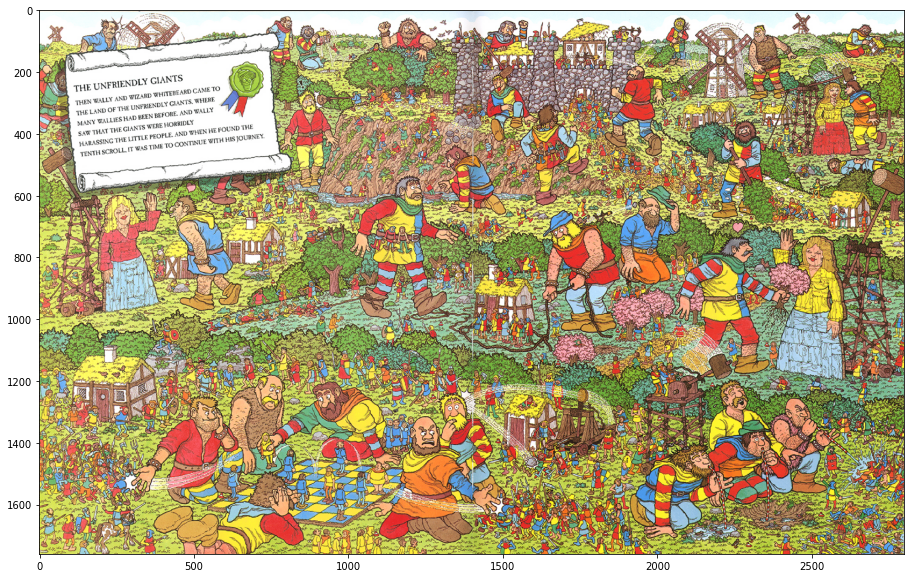

In [ ]:
# resize를 통해 2800x1760으로 전체 이미지 크기로 조정, 255로 나누어 0~1사이로 변환
img_filename = '02.jpg' 
test_img = np.array(Image.open(os.path.join('test_imgs', img_filename)).resize((2800, 1760), Image.NEAREST)).astype(np.float32) / 255.

# 테스트데이터 시각화
plt.figure(figsize=(20, 10))
plt.imshow(test_img)

**Helper Functions (Resize, Split, Combine Pannels)**

In [ ]:
# 이미지 crop시 남게되는 이미지 문제 발생
# 224의 배수로 resize
def img_resize(img):
    h, w, _ = img.shape
    nvpanels = int(h/PANNEL_SIZE)
    nhpanels = int(w/PANNEL_SIZE)
    new_h, new_w = h, w
    if nvpanels*PANNEL_SIZE != h:
        new_h = (nvpanels+1)*PANNEL_SIZE
    if nhpanels*PANNEL_SIZE != w:
        new_w = (nhpanels+1)*PANNEL_SIZE
    if new_h == h and new_w == w:
        return img
    else:
        return resize(img, output_shape=(new_h, new_w), preserve_range=True)

# 224x224로 분할하여 모델에 넣기 쉽게 batch화
def split_panels(img):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    panels = []
    for i in range(num_vert_panels):
        for j in range(num_hor_panels):
            panels.append(img[i*PANNEL_SIZE:(i+1)*PANNEL_SIZE, j*PANNEL_SIZE:(j+1)*PANNEL_SIZE])
    return np.stack(panels)

# 분할된 이미지를 하나로 되합치기 (이미지가 제대로 복원되는지)
def combine_panels(img, panels):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    total = []
    p = 0
    for i in range(num_vert_panels):
        row = []
        for j in range(num_hor_panels):
            row.append(panels[p])
            p += 1
        total.append(np.concatenate(row, axis=1))
    return np.concatenate(total, axis=0)

**Preprocess Image**

In [ ]:
test_img = img_resize(test_img)         # resize

panels = split_panels(test_img)         # split

out = combine_panels(test_img, panels)  # combine

# 패널의 개수 : 104, 테스트 이미지 : 1792x2912,다시 컴바인해도 : 1792x2912
print(panels.shape, test_img.shape, out.shape)

(104, 224, 224, 3) (1792, 2912, 3) (1792, 2912, 3)


**Predict**

(550, 1168) 95.03%


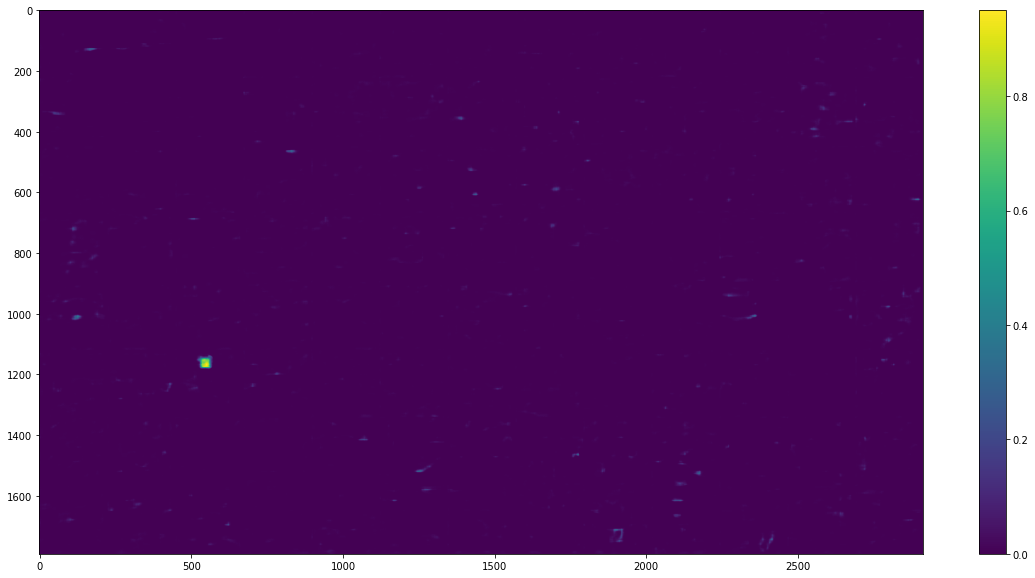

In [ ]:
# 모델 로드
model = load_model('model.h5')

# 예측 결과값 2채널중 1번 채널(전부 1로 채워진) 224x224 이미지 사이즈에 맞게 변환
pred_panels = model.predict(panels).reshape((-1, PANNEL_SIZE, PANNEL_SIZE, 2))[:, :, :, 1]

# pred panels를 컴바인 패널로 테스트 이미지와 같은 크기로 합치기
pred_out = combine_panels(test_img, pred_panels)

# 좌표와 신뢰도 계산 
argmax_x = np.argmax(np.max(pred_out, axis=0), axis=0)
argmax_y = np.argmax(np.max(pred_out, axis=1), axis=0)
confidence = np.amax(pred_out) * 100

print('(%s, %s) %.2f%%' % (argmax_x, argmax_y, confidence))

# 이미지 시각화 (월리가 있는곳은 1)
plt.figure(figsize=(20, 10))
plt.imshow(pred_out)
plt.colorbar()

**Make Overlay for Result**

538 1152 559 1175


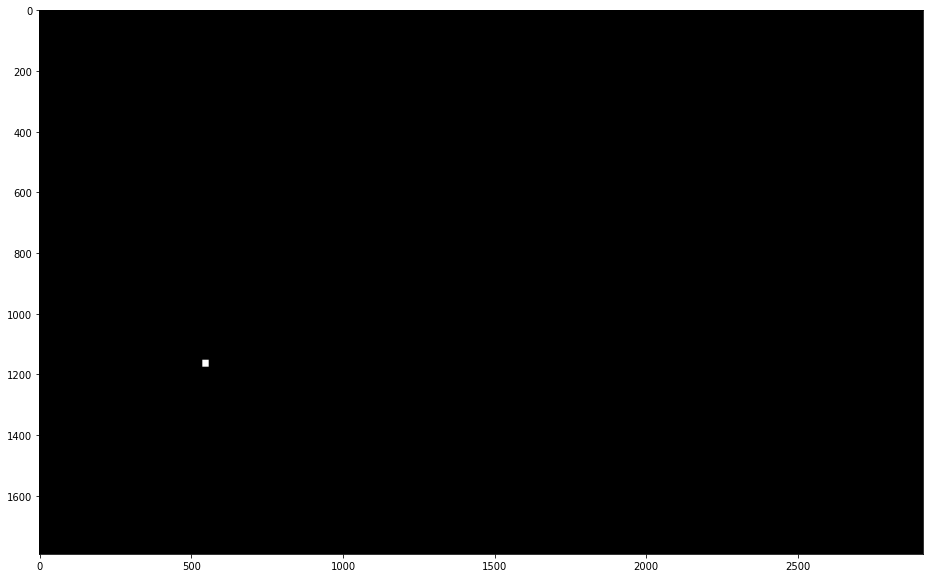

In [ ]:
# 마스크 생성 (월리가 있는곳)
def bbox_from_mask(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return x1, y1, x2, y2

x1, y1, x2, y2 = bbox_from_mask((pred_out > 0.8).astype(np.uint8))
print(x1, y1, x2, y2)

# 오버레이 생성 (월리가 있는곳만 하얗게 표시)
overlay = np.repeat(np.expand_dims(np.zeros_like(pred_out, dtype=np.uint8), axis=-1), 3, axis=-1)
alpha = np.expand_dims(np.full_like(pred_out, 255, dtype=np.uint8), axis=-1)

overlay = np.concatenate([overlay, alpha], axis=-1)

overlay[y1:y2, x1:x2, 3] = 0

# 오버레이 시각화
plt.figure(figsize=(20, 10))
plt.imshow(overlay)

**Final Result**

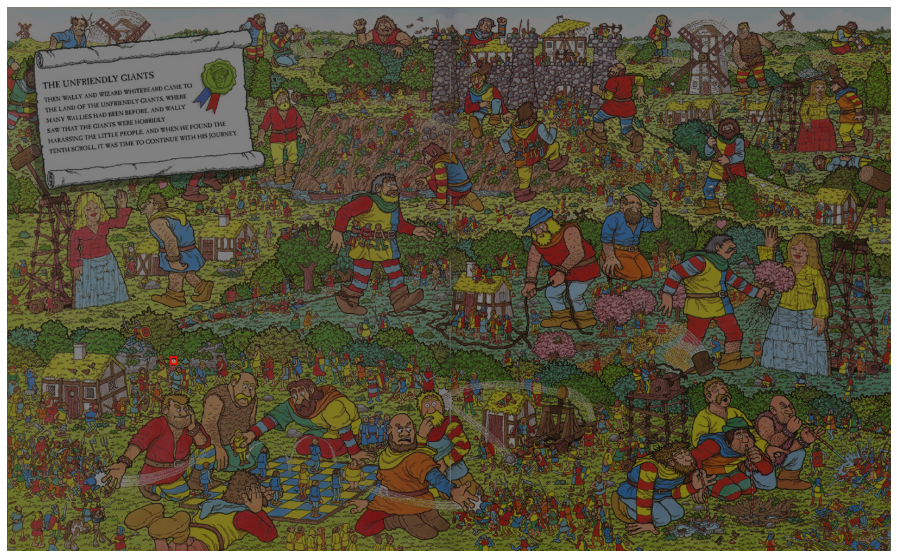

In [ ]:
# 최종 예측
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(test_img)           # 원본 테스트 이미지
ax.imshow(overlay, alpha=0.5) # 생성한 오버레이 입히기

# 월리가 있는곳 사각형 표시
rect = patches.Rectangle((x1, y1), width=x2-x1, height=y2-y1, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.set_axis_off()

# 결과 사진 저장
fig.savefig(os.path.join('test_result', img_filename), bbox_inches='tight')